In [1]:
import numpy as np
import pandas as pd
from IPython.display import HTML

from collab2.foraging.toolkit import (
    _add_velocity,
    _generic_velocity_predictor,
    _velocity_predictor_contribution,
    animate_predictors,
    dataObject,
    generate_local_windows,
    generate_pairwiseCopying_predictor,
    plot_predictor,
    rescale_to_grid,
    subsample_frames_constant_frame_rate,
)

In [2]:
# create a test object with random data
num_frames = 8
num_foragers = 4
grid_size = 30
n_nans = int(num_frames * num_foragers / 5)
n_missing = int(num_frames * num_foragers / 5)
gridMin = -1
gridMax = 1

np.random.seed(42)

# generate data in a unit disk
theta = 2 * np.pi * np.random.rand(num_frames * num_foragers)
r = np.random.rand(num_frames * num_foragers)

data = {
    "x": r * np.cos(theta),
    "y": r * np.sin(theta),
    "time": np.tile(np.arange(num_frames), num_foragers),
    "forager": np.concatenate([i * np.ones(num_frames) for i in range(num_foragers)]),
}

foragersDF = pd.DataFrame(data)

# # add nan values
# nan_ind = np.random.randint(0, num_frames * num_foragers, size=n_nans)
# foragersDF.loc[nan_ind, ["x", "y"]] = np.nan

# # remove values for certain time points
# drop_ind = np.random.randint(0, num_frames * num_foragers, size=n_missing)
# foragersDF = foragersDF.drop(drop_ind)

# scaling and subsampling
foragersDF_scaled = rescale_to_grid(
    foragersDF, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
foragers_object = dataObject(foragersDF_scaled, grid_size=grid_size)

In [3]:
# get local windows
local_windows_kwargs = {
    "window_size": 10,
    "sampling_fraction": 1,
    "skip_incomplete_frames": False,
}

foragers_object.local_windows_kwargs = local_windows_kwargs

local_windows = generate_local_windows(foragers_object)

# Illustration of visualization function
The function takes in any nested list structure (i.e. `local_windows`-like), and plots the value of the column `predictorID` at the specified grid points for a given list of foragers and time frames

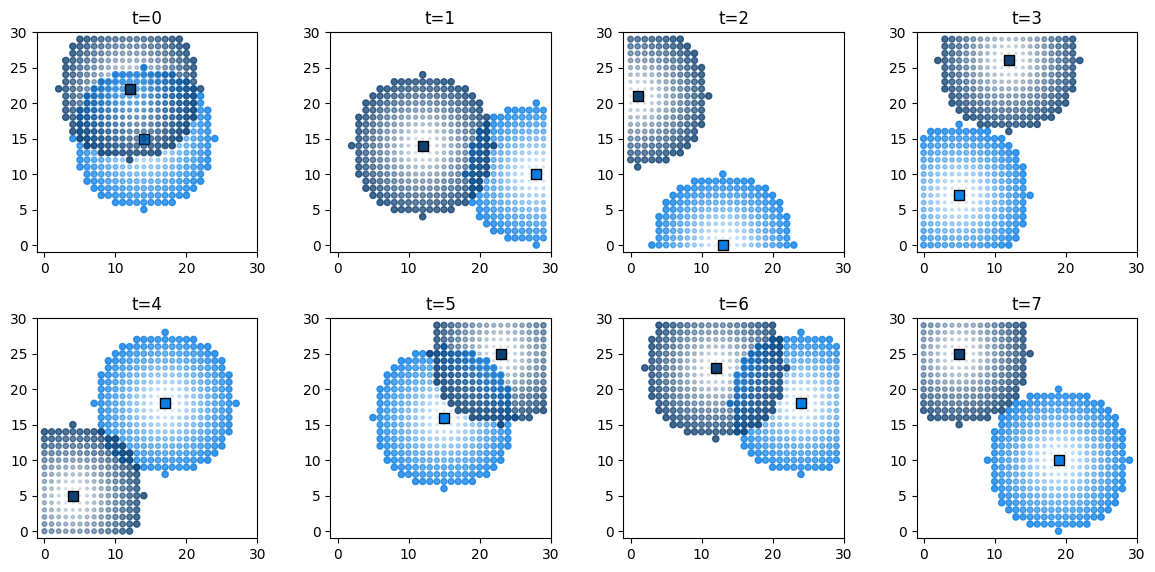

In [4]:
plot_predictor(
    foragers_object.foragers,
    local_windows,
    predictorID="distance_to_forager",
    forager_index=[0, 2],
    time=range(num_frames),
    grid_size=grid_size,
    size_multiplier=20,
    random_state=10,  # selects the plot colors
)

# Illustration of velocity predictor calculation
`_velocity_predictor_contribution(..)` assigns a predictor score to every grid point given a preferred ($v$, $\theta$), location of focal forager, and chosen gaussian widths

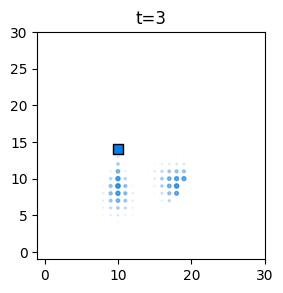

In [5]:
# visualize  velocity_predictor_contribution for a test case
test_pred = [[None for i in range(num_frames)] for j in range(num_foragers)]

# compute the predictor contribution for a random case
f = 3
t = 3
x = foragers_object.foragers[f].loc[t, "x"]
y = foragers_object.foragers[f].loc[t, "y"]
sigma_v = 2
sigma_t = np.pi / 20

v_pref1 = 5
theta_pref1 = -np.pi / 2
v_pred1 = _velocity_predictor_contribution(
    v_pref1, theta_pref1, x, y, local_windows[f][t], sigma_v, sigma_t
)

v_pref2 = 10
theta_pref2 = -np.pi / 6
v_pred2 = _velocity_predictor_contribution(
    v_pref2, theta_pref2, x, y, local_windows[f][t], sigma_v, sigma_t
)

# additive combination
test_pred[f][t] = local_windows[f][t].copy()
test_pred[f][t]["v_pred"] = (v_pred1 + v_pred2) / 2


plot_predictor(
    foragers_object.foragers,
    test_pred,
    "v_pred",
    [f],
    [t],
    grid_size,
    size_multiplier=10,
    random_state=10,
)

# Random pairwise copying predictor

In [6]:
# define the transformation function


def transformation_pairwiseCopying(v_values):
    return v_values

# Test on real data

original_frames: 18739
original_shape: (74956, 5)
resulting_frames: 313
resulting_shape: (1252, 5)


/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/utils.py:42: UserWarning: 
                NaN values in data. The default behavior of predictor/score generating functions is
                to ignore foragers with missing positional data. To modify, see documentation of
                `derive_predictors_and_scores` and `generate_local_windows`
                
  warnings.warn(


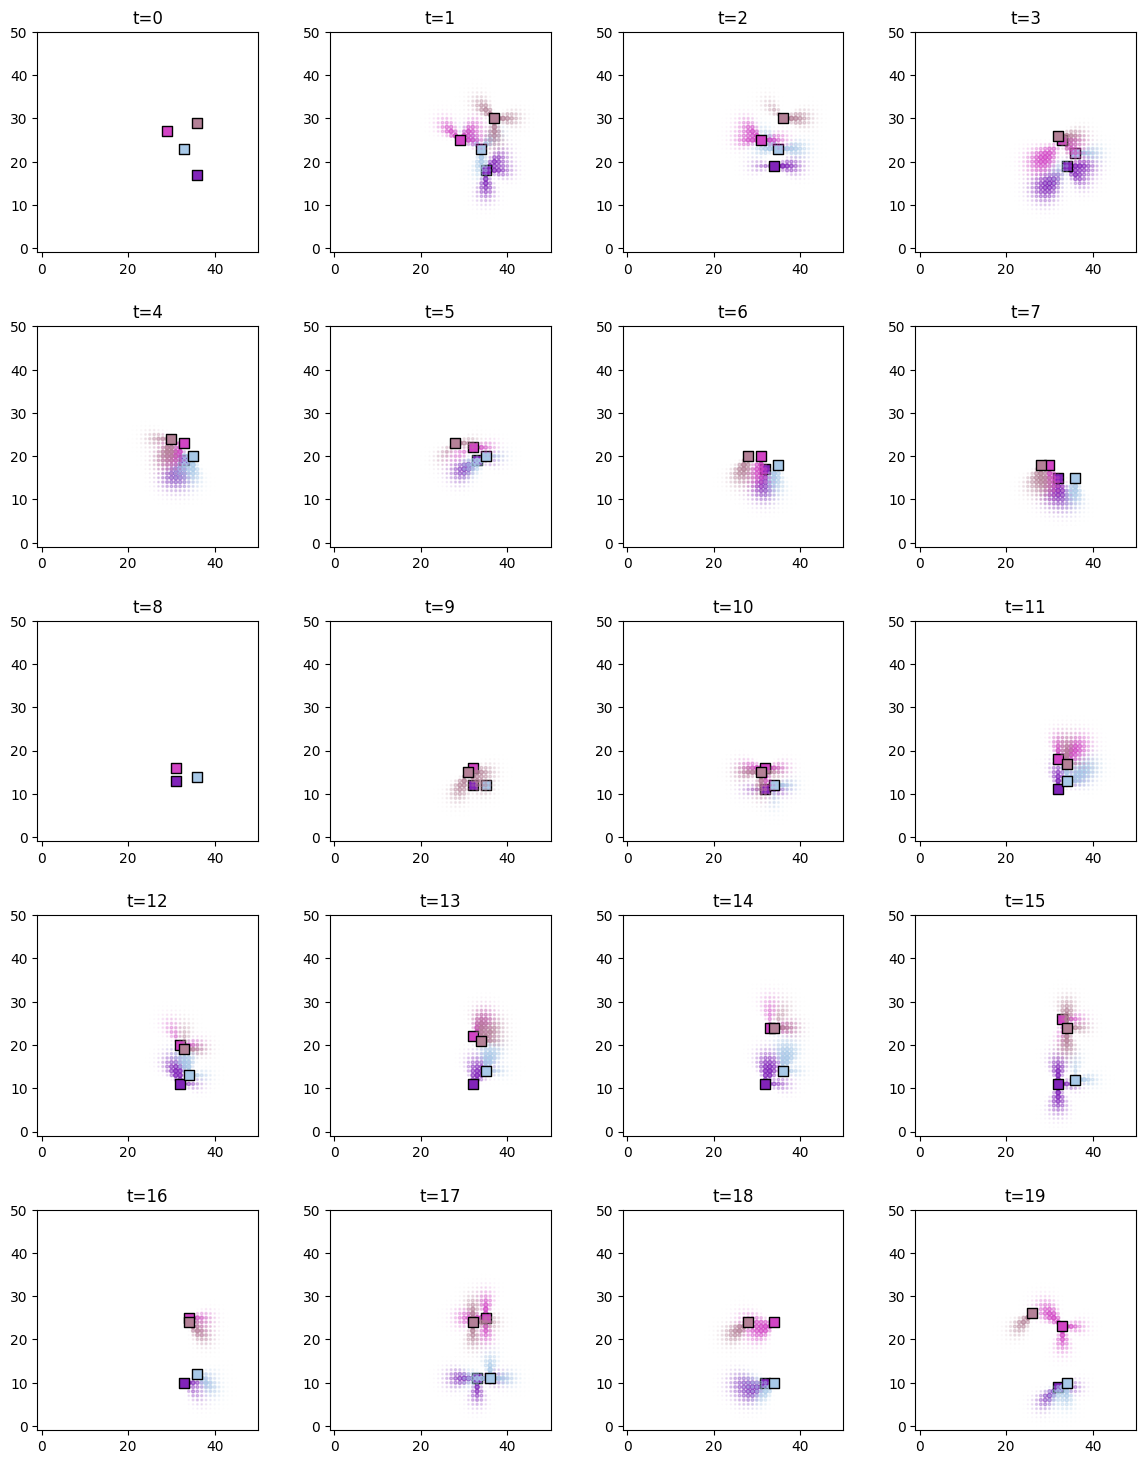

In [7]:
# load data
fish_data = pd.read_csv("4wpf_test.csv")
gridMin = 0
gridMax = 300
grid_size = 50
fps = 121

# scaling and subsampling
fishDF_scaled = rescale_to_grid(
    fish_data, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
fishDF_scaled_subsampled = subsample_frames_constant_frame_rate(
    fishDF_scaled, frame_spacing=60
)

# create a test foragers object with 20 frames
num_frames = 20
foragers_object = dataObject(
    fishDF_scaled_subsampled.loc[fishDF_scaled_subsampled["time"] < 20],
    grid_size=grid_size,
)

# get local windows
local_windows_kwargs = {
    "window_size": grid_size / 2,
    "sampling_fraction": 1,
    "skip_incomplete_frames": True,
}

foragers_object.local_windows_kwargs = local_windows_kwargs

local_windows = generate_local_windows(foragers_object)

# add velocity and compute predictor using unexposed function
foragers, foragersDF = _add_velocity(foragers_object.foragers, dt=1)
predictor = _generic_velocity_predictor(
    foragers,
    foragersDF,
    local_windows,
    predictor_name="pred",
    transformation_function=transformation_pairwiseCopying,
    interaction_length=grid_size / 3,
    interaction_constraint=None,
    interaction_constraint_params=None,
    dt=1,
    sigma_v=3,
    sigma_t=0.3,
)

# visualize predictor
plot_predictor(
    foragers,
    predictor,
    "pred",
    [0, 1, 2, 3],
    range(num_frames),
    grid_size,
    size_multiplier=10,
    random_state=99,
)

# Animations

/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/visualization.py:138: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
2024-09-03 19:07:09,547 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


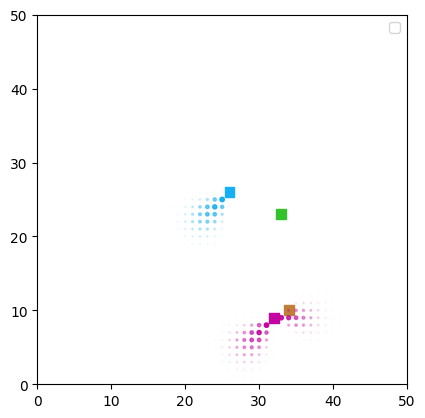

In [8]:
ani = animate_predictors(
    foragers_object.foragersDF,
    predictor,
    predictor_name="pred",
    forager_index=[0, 3],
    grid_size=grid_size,
    random_state=10,
    size_multiplier=10,
)
HTML(ani.to_jshtml())

# Adding interaction constraint

In [16]:
# suppose copying only occurs when velocity is > 1


def filter_max_v(f_ind, f, t, foragersDF, v_thresh,v_name):
    current_positions = foragersDF.loc[
        np.logical_and(foragersDF["forager"].isin(f_ind), foragersDF["time"] == t)
    ]
    f_ind_constr = current_positions.loc[
        current_positions[v_name] > v_thresh, "forager"
    ].to_list()
    return f_ind_constr

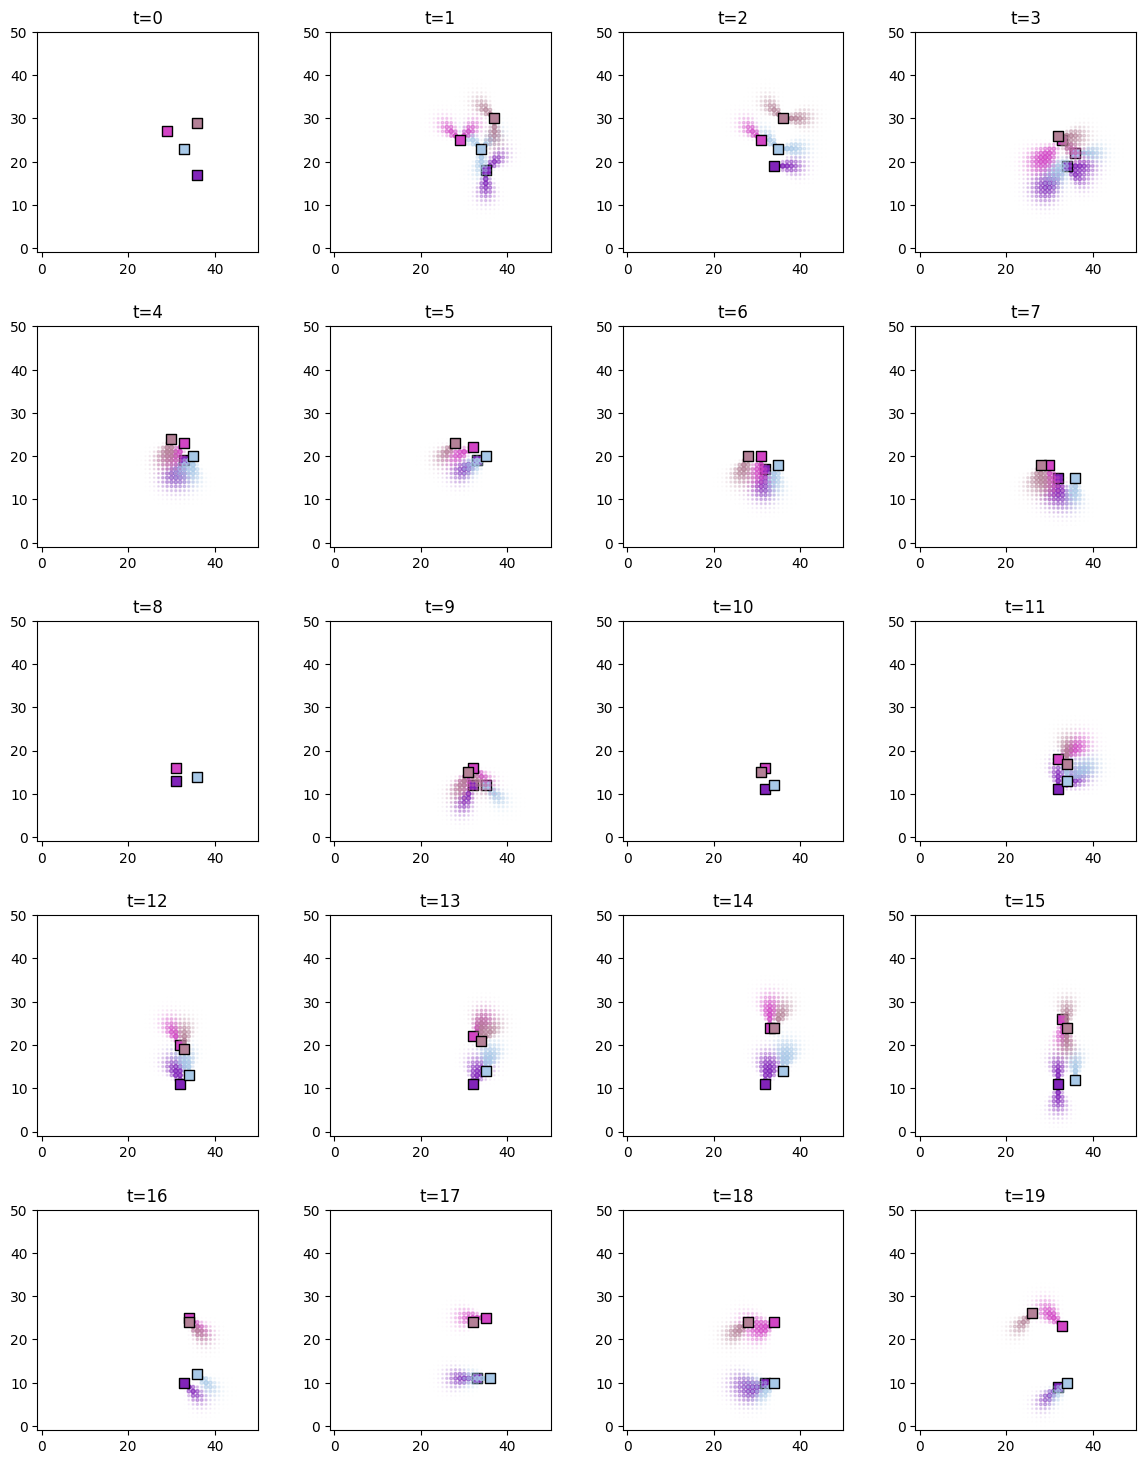

In [18]:
# compute predictor again, now with constraint
predictor = _generic_velocity_predictor(
    foragers,
    foragersDF,
    local_windows,
    predictor_name="pred",
    transformation_function=transformation_pairwiseCopying,
    interaction_length=grid_size / 3,
    interaction_constraint=filter_max_v,
    v_thresh = 1,
    v_name = "v_dt=1",
    dt=1,
    sigma_v=3,
    sigma_t=0.3,
)

# visualize predictor
plot_predictor(
    foragers,
    predictor,
    "pred",
    [0, 1, 2, 3],
    range(num_frames),
    grid_size,
    size_multiplier=10,
    random_state=99,
)

/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/visualization.py:138: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
2024-09-03 19:09:56,254 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


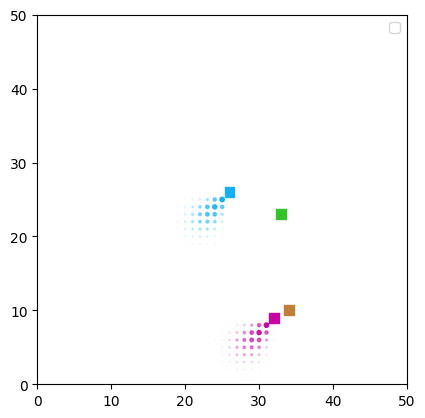

In [19]:
ani = animate_predictors(
    foragers_object.foragersDF,
    predictor,
    predictor_name="pred",
    forager_index=[0, 3],
    grid_size=grid_size,
    random_state=10,
    size_multiplier=10,
)
HTML(ani.to_jshtml())

# Finally, test the pipeline with non-underscored function

original_frames: 18739
original_shape: (74956, 5)
resulting_frames: 313
resulting_shape: (1252, 5)


/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/utils.py:42: UserWarning: 
                NaN values in data. The default behavior of predictor/score generating functions is
                to ignore foragers with missing positional data. To modify, see documentation of
                `derive_predictors_and_scores` and `generate_local_windows`
                
  warnings.warn(
/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/visualization.py:138: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
2024-09-03 19:10:56,064 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


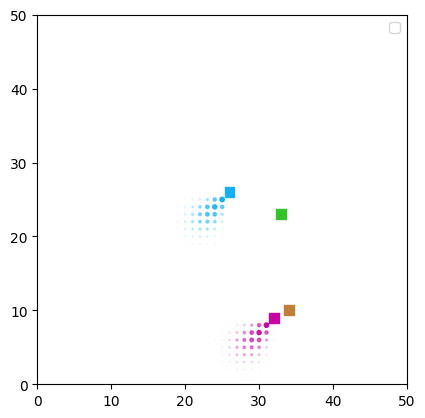

In [20]:
# load data
fish_data = pd.read_csv("4wpf_test.csv")
gridMin = 0
gridMax = 300
grid_size = 50
fps = 121

# scaling and subsampling
fishDF_scaled = rescale_to_grid(
    fish_data, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
fishDF_scaled_subsampled = subsample_frames_constant_frame_rate(
    fishDF_scaled, frame_spacing=60
)

# create a test foragers object with 20 frames
num_frames = 20
foragers_object = dataObject(
    fishDF_scaled_subsampled.loc[fishDF_scaled_subsampled["time"] < 20],
    grid_size=grid_size,
)

# generate local windows and add to object
local_windows_kwargs = {
    "window_size": grid_size / 2,
    "sampling_fraction": 1,
    "skip_incomplete_frames": True,
}
foragers_object.local_windows_kwargs = local_windows_kwargs
local_windows = generate_local_windows(foragers_object)
foragers_object.local_windows = local_windows

# choose predictor parameters and add to object
predictor_kwargs = {
    "pred": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": filter_max_v,
        "v_thresh": 1, 
        "v_name": "v_dt=1",
        "dt": 1,
        "sigma_v": 3,
        "sigma_t": 0.3,
    }
}

foragers_object.predictor_kwargs = predictor_kwargs

predictor = generate_pairwiseCopying_predictor(foragers_object, "pred")

ani = animate_predictors(
    foragers_object.foragersDF,
    predictor,
    predictor_name="pred",
    forager_index=[0, 3],
    grid_size=grid_size,
    random_state=10,
    size_multiplier=10,
)
HTML(ani.to_jshtml())